In [171]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

## Preprocess

In [115]:
# Load the crimes data
data = pd.read_csv('project_data.csv')
data.drop(columns=['X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'IUCR', 'Case Number', 'Description'], inplace=True)

# Load the weather data
temperatures = pd.read_csv('data/daily_chicago_weather_2022.csv')

# Constants
CRITICAL_Z = 1.5
NUM_SAMPLES = 1000
CONFIDENCE = 0.95
K = 1

In [116]:
seasons_mapping = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

locations_mapping = {
    'RESIDENCE': 'RESIDENCE',
    'APARTMENT': 'RESIDENCE',
    'STREET': 'STREET',
    'COMMERalphaAL / BUSINESS OFFICE': 'OFFICE',
    'HOSPITAL BUILDING / GROUNDS': 'HOSPITAL',
    'WAREHOUSE': 'WAREHOUSE',
    'VEHICLE - COMMERalphaAL': 'VEHICLE',
    'SCHOOL - PUBLIC GROUNDS': 'SCHOOL',
    'OTHER (SPEalphaFY)': 'OTHER',
    'GOVERNMENT BUILDING / PROPERTY': 'GOVERNMENT_PROPERTY',
    'RESIDENCE - PORCH / HALLWAY': 'RESIDENCE',
    'SIDEWALK': 'STREET',
    'PARKING LOT / GARAGE (NON RESIDENTIAL)': 'PARKING_LOT',
    'BANK': 'BANK',
    'ALLEY': 'STREET',
    'POLICE FAalphaLITY / VEHICLE PARKING LOT': 'POLICE FAalphaLITY',
    'MOVIE HOUSE / THEATER': 'THEATER',
    'VEHICLE NON-COMMERalphaAL': 'VEHICLE',
    'OTHER RAILROAD PROPERTY / TRAIN DEPOT': 'PUBLIC_TRANSPORT',
    'SCHOOL - PUBLIC BUILDING': 'SCHOOL',
    'DAY CARE CENTER': 'DAY CARE CENTER',
    'VEHICLE - OTHER RIDE SHARE SERVICE (LYFT, UBER, ETC.)': 'VEHICLE',
    'BAR OR TAVERN': 'BAR',
    'CTA PLATFORM': 'PUBLIC_TRANSPORT',
    'AUTO / BOAT / RV DEALERSHIP': 'OFFICE',
    'SMALL RETAIL STORE': 'STORE',
    'GAS STATION': 'GAS STATION',
    'RESIDENCE - YARD (FRONT / BACK)': 'RESIDENCE',
    'RESTAURANT': 'BUSINESSES',
    'PARKING LOT': 'PARKING LOT',
    'VACANT LOT / LAND': 'VACANT',
    'BARBERSHOP': 'BUSINESSES',
    'CTA BUS STOP': 'PUBLIC_TRANSPORT',
    'RESIDENCE - GARAGE': 'RESIDENCE',
    'HOUSE': 'RESIDENCE',
    'HOTEL / MOTEL': 'HOTEL',
    'DEPARTMENT STORE': 'BUSINESSES',
    'ATM (AUTOMATIC TELLER MACHINE)': 'ATM',
    'JAIL / LOCK-UP FACILITY': 'JAIL',
    'ABANDONED BUILDING': 'VACANT',
    'DRIVEWAY - RESIDENTIAL': 'RESIDENCE',
    'PARK PROPERTY': 'PARK',
    'FEDERAL BUILDING': 'GOVERNMENT_PROPERTY',
    'CLEANING STORE': 'BUSINESSES',
    'MEDICAL / DENTAL OFFICE': 'BUSINESSES',
    'ATHLETIC CLUB': 'SPORT',
    'FACTORY / MANUFACTURING BUILDING': 'FACTORY',
    'CONVENIENCE STORE': 'BUSINESSES',
    'CONSTRUCTION SITE': 'OTHER',
    'CURRENCY EXCHANGE': 'CURRENCY_EXCHANGE',
    'GROCERY FOOD STORE': 'BUSINESSES',
    'AIRPORT PARKING LOT': 'PARKING_LOT',
    'CHURCH / SYNAGOGUE / PLACE OF WORSHIP': 'RELIGIOUS',
    'DRUG STORE': 'MEDICAL',
    'APPLIANCE STORE': 'BUSINESSES',
    'SPORTS ARENA / STADIUM': 'SPORT',
    'CHA APARTMENT': 'RESIDENCE',
    'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA': 'AIRPORT',
    'OTHER COMMERCIAL TRANSPORTATION': 'PUBLIC_TRANSPORT',
    'CREDIT UNION': 'OTHER',
    'AIRPORT EXTERIOR - NON-SECURE AREA': 'AIRPORT',
    'CTA BUS': 'PUBLIC_TRANSPORT',
    'AIRPORT VENDING ESTABLISHMENT': 'AIRPORT',
    'BOWLING ALLEY': 'BUSINESSES',
    'SCHOOL - PRIVATE GROUNDS': 'SCHOOL',
    'AIRPORT/AIRCRAFT': 'AIRPORT',
    'NURSING / RETIREMENT HOME': 'RETIREMENT_HOME',
    'AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA': 'AIRPORT',
    'TAVERN / LIQUOR STORE': 'BAR',
    'SCHOOL - PRIVATE BUILDING': 'SCHOOL',
    'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA': 'AIRPORT',
    'CAR WASH': 'BUSINESSES',
    'CTA TRAIN': 'PUBLIC_TRANSPORT',
    'CHA PARKING LOT / GROUNDS': 'PARKING_LOT',
    'LIBRARY': 'BUSINESSES',
    'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA': 'AIRPORT',
    'FIRE STATION': 'PUBLIC_BUILDING',
    'CTA STATION': 'PUBLIC_TRANSPORT',
    'GARAGE': 'BUSINESSES',
    'TAVERN': 'BAR',
    'COLLEGE / UNIVERSITY - RESIDENCE HALL': 'PUBLIC_BUILDING',
    'YARD': 'PARK',
    'AUTO': 'OTHER',
    'AIRPORT BUILDING NON-TERMINAL - SECURE AREA': 'AIRPORT',
    'BOAT / WATERCRAFT': 'VEHICLE',
    'VESTIBULE': 'OTHER',
    'LAKEFRONT / WATERFRONT / RIVERBANK': 'PARK',
    'AIRCRAFT': 'AIRCRAFT',
    'VEHICLE - DELIVERY TRUCK': 'VEHICLE',
    'PAWN SHOP': 'BUSINESSES',
    'PORCH': 'RESIDENCE',
    'CTA PROPERTY': 'PUBLIC_TRANSPORT',
    'HALLWAY': 'OTHER',
    'BANQUET HALL': 'PUBLIC_BUILDING',
    'RETAIL STORE': 'BUSINESSES',
    'CHA PARKING LOT': 'PARKING_LOT',
    'CTA "L" TRAIN': 'PUBLIC_TRANSPORT',
    'HOTEL': 'HOTEL',
    'SCHOOL YARD': 'SCHOOL',
    'VACANT LOT': 'VACANT',
    'CHA GROUNDS': 'VACANT',
    'GAS STATION DRIVE/PROP.': 'PUBLIC_BUILDING',
    'DRIVEWAY': 'PARKING_LOT',
    'BASEMENT': 'RESIDENCE',
    'BARBER SHOP/BEAUTY SALON': 'BUSINESSES',
    'CHA LOBBY': 'PUBLIC_BUILDING',
    'RAILROAD PROPERTY': 'PUBLIC_TRANSPORT',
    'POLICE FACILITY': 'POLICE',
    'RIVER BANK': 'PARK',
    'LIQUOR STORE': 'BAR',
    'OFFICE': 'OFFICE',
    'TRUCK': 'VEHICLE',
    'PUBLIC GRAMMAR SCHOOL': 'SCHOOL',
    'STAIRWELL': 'OTHER',
    'ANIMAL HOSPITAL': 'BUSINESSES',
    'CHA HALLWAY / STAIRWELL / ELEVATOR': 'OTHER',
    'CTA PARKING LOT / GARAGE / OTHER PROPERTY': 'PARKING_LOT',
    'TAXICAB': 'VEHICLE',
    'AIRPORT TERMINAL LOWER LEVEL - SECURE AREA': 'AIRPORT',
    'COLLEGE / UNIVERSITY - GROUNDS': 'PUBLIC_BUILDING',
    'BRIDGE': 'STREET',
    'AIRPORT EXTERIOR - SECURE AREA': 'AIRPORT',
    'COIN OPERATED MACHINE': 'ATM',
    'AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA': 'AIRPORT',
    'POOL ROOM': 'BUSINESSES',
    'CTA TRACKS - RIGHT OF WAY': 'PUBLIC_TRANSPORT',
    'SAVINGS AND LOAN': 'BANK',
    'HIGHWAY / EXPRESSWAY': 'VEHICLE',
    'AIRPORT TRANSPORTATION SYSTEM (ATS)': 'AIRPORT',
    'FOREST PRESERVE': 'PARK',
    'VEHICLE - COMMERCIAL: TROLLEY BUS': 'VEHICLE',
    'CEMETARY': 'PUBLIC_BUILDING',
    'VEHICLE - COMMERCIAL: ENTERTAINMENT / PARTY BUS': 'VEHICLE',
    'FARM': 'RESIDENCE',
}

part_of_day_mapping = {
    '0': 'Night',
    '1': 'Night',
    '2': 'Night',
    '3': 'Night',
    '4': 'Night',
    '5': 'Night',
    '6': 'Morning',
    '7': 'Morning',
    '8': 'Morning',
    '9': 'Morning',
    '10': 'Morning',
    '11': 'Morning',
    '12': 'Afternoon',
    '13': 'Afternoon',
    '14': 'Afternoon',
    '15': 'Afternoon',
    '16': 'Afternoon',
    '17': 'Afternoon',
    '18': 'Evening',
    '19': 'Evening',
    '20': 'Evening',
    '21': 'Evening',
    '22': 'Evening',
    '23': 'Evening',
}

def fahrenheit_to_celsius(temp):
    return (temp - 32) * 5 / 9

def date_to_season(date):
    month = int(date.split('/')[0])
    for season in seasons_mapping.keys():
        if month in seasons_mapping[season]:
            return season

def format_date(date_str):
    month, day, year = date_str.split('/')
    month = int(month)
    day = int(day)
    return f"{month}/{day}"

# Todo: Check if the day is a week day or a weekend

# Create a dictionary that maps each day to the average temperature
day_to_temp = {}
for index, row in temperatures.iterrows():
    day_to_temp[format_date(row['date'])] = row['temp_avg']


# Reformating the date for the data df
days = []
for index, row in data.iterrows():
    days.append(format_date(row['Date'].split(' ')[0]))

# Extracting the day from the date
data['day'] = pd.Series(days)

# Mapping the locations to a more general category
data['Location Description'] = data['Location Description'].apply(lambda x: locations_mapping[x] if x in locations_mapping else 'OTHER')
data.rename(columns={'Location Description': 'Location'}, inplace=True)

# Mapping the time of the day to a more general category
data['part_of_day'] = data['Date'].apply(lambda x: part_of_day_mapping[x.split(' ')[1].split(':')[0]])

# Extracting the hour from the date
data['hour'] = data['Date'].apply(lambda x: round(float(x.split(' ')[1].split(':')[0]) + float(x.split(' ')[1].split(':')[1]) / 60, 2))

# Mapping the days to seasons and adding the temperature
data['season'] = data['Date'].apply(date_to_season)
data['temperature'] = data['day'].apply(lambda x: round(fahrenheit_to_celsius(day_to_temp[x]), 1))

In [117]:
# Normalizing the temperature and define treatment as Z-score > critical Z-score
seasons_temperature_stats = data.groupby(['season'])['temperature'].aggregate(['mean', 'std'])
seasons_mean = seasons_temperature_stats['mean']
seasons_std = seasons_temperature_stats['std']

data['normalized_temperature'] = data.apply(lambda x: (x['temperature'] - seasons_mean[x['season']]) / seasons_std[x['season']], axis=1)
data['T'] = data['normalized_temperature'] > CRITICAL_Z

## Exploration

In [ ]:


# Perform t-test between high and low temp groups
t_stat, p_value = stats.ttest_ind(data[data['T'] == 1]['Arrest'], data[data['T'] == 0]['Arrest'])
print(f'T-Statistic: {t_stat:.2f}, P-value: {p_value:.3f}')


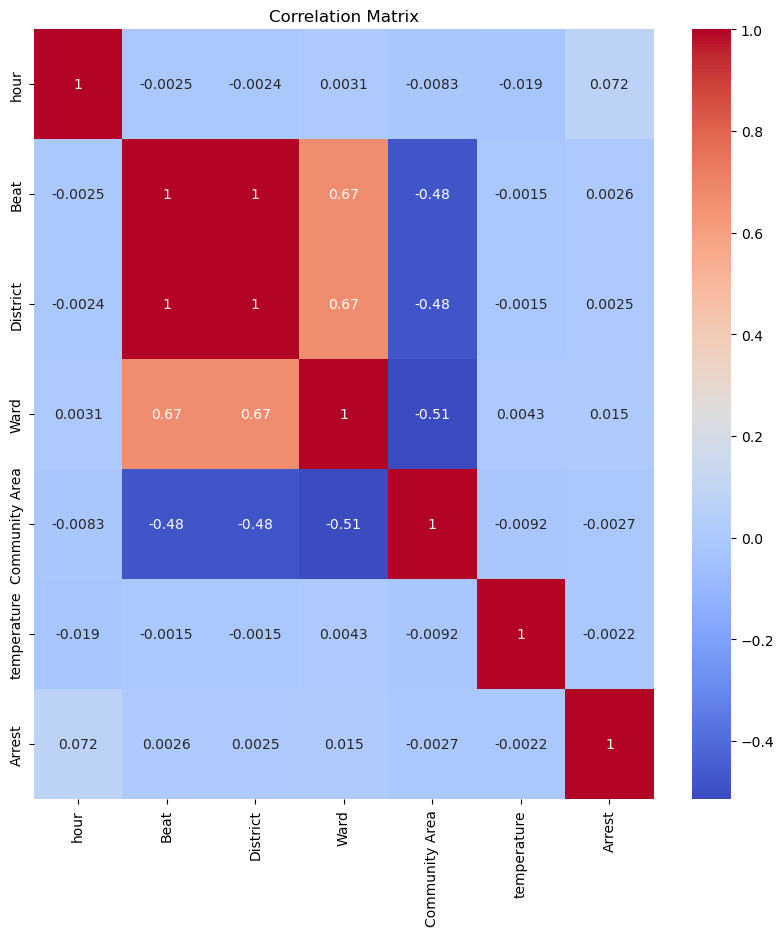

In [163]:
# Correlation matrix
corr_matrix = data[['hour', 'Beat', 'District', 'Ward', 'Community Area', 'temperature', 'Arrest']].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [112]:
# Calculate arrest rates in high vs. low temperature
high_temp_arrest_rate = data[data['T'] == 1]['Arrest'].mean()
low_temp_arrest_rate = data[data['T'] == 0]['Arrest'].mean()

print(f"High Temperature Arrest Rate: {high_temp_arrest_rate:.2f}")
print(f"Low Temperature Arrest Rate: {low_temp_arrest_rate:.2f}")


High Temperature Arrest Rate: 0.13
Low Temperature Arrest Rate: 0.12


In [172]:
X = data.drop(columns=['ID', 'Date', 'Block', 'FBI Code', 'temperature', 'normalized_temperature', 'Arrest'])
y = data['Arrest']
T = data['T']

X['Beat'] = X['Beat'].astype(str)
X['District'] = X['District'].astype(str)
X['Ward'] = X['Ward'].astype(str)
X['Community Area'] = X['Community Area'].astype(str)
X = X.replace({'T': {True: 'True', False: 'False'}})

crimes_per_day = data.groupby(['day'])['ID'].aggregate('count')
arrests_percentage = data.groupby(['day'])['Arrest'].aggregate('mean')

#### Crime rates and Arrest rates

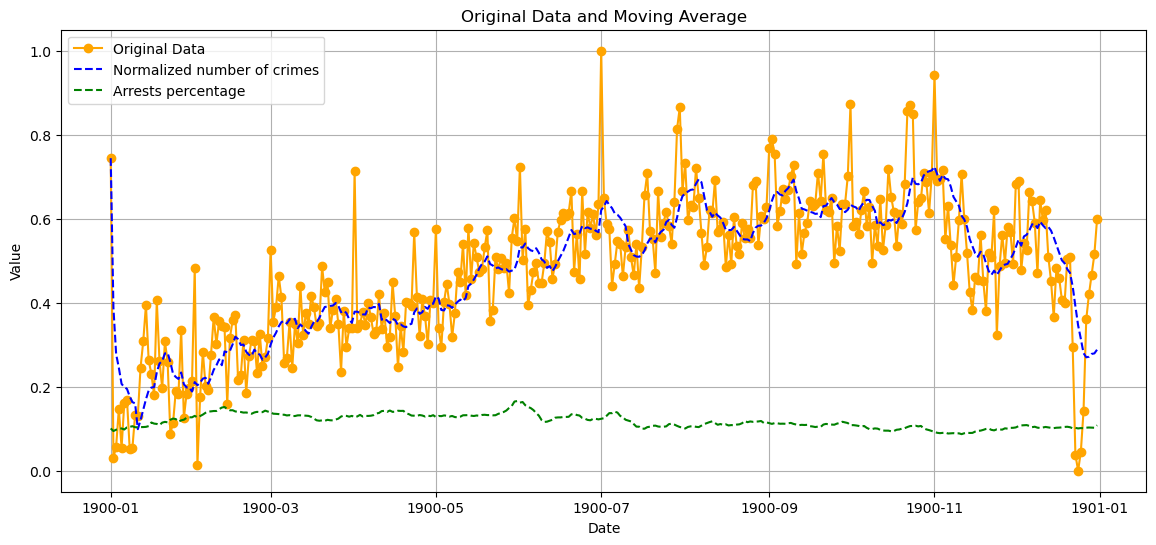

In [84]:
# Apply Min-Max normalization on the number of crimes per day
min_value = crimes_per_day.min()
max_value = crimes_per_day.max()
crimes_per_day_normalized = (crimes_per_day - min_value) / (max_value - min_value)


crimes_per_day_normalized.index = pd.to_datetime(crimes_per_day_normalized.index, format='%m/%d')
crimes_per_day_normalized = crimes_per_day_normalized.sort_index()


arrests_percentage.index = pd.to_datetime(arrests_percentage.index, format='%m/%d')
arrests_percentage = arrests_percentage.sort_index()

# Calculate moving average
window_length = 10
crimes_moving_avg = crimes_per_day_normalized.rolling(window=window_length, min_periods=1).mean()
arrests_moving_avg = arrests_percentage.rolling(window=window_length, min_periods=1).mean()

# Plot the results
plt.figure(figsize=(14,6))
plt.plot(crimes_per_day_normalized.index, crimes_per_day_normalized, label='Original Data', marker='o', color='orange')
plt.plot(crimes_per_day_normalized.index, crimes_moving_avg, label='Normalized number of crimes', linestyle='--', color='blue')
plt.plot(arrests_percentage.index, arrests_moving_avg, label='Arrests percentage', linestyle='--', color='green')



# plt.xticks(
#     ticks=[0, 31, 59, 90, 120, 151, 181, 212, 334, 1000, 5000, 10000],
#     labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Data and Moving Average')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Looking for confounders

#### Primary Type

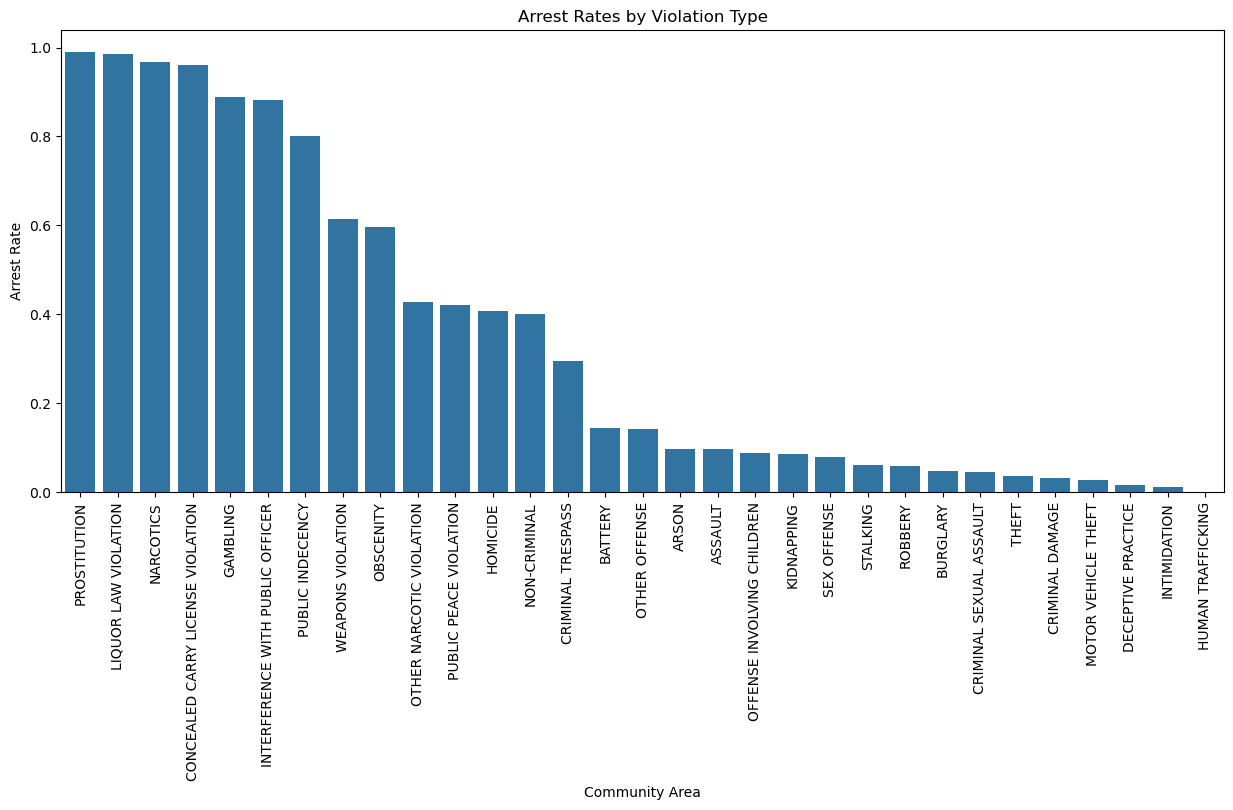

In [164]:
arrest_by_violation_type = data.groupby('Primary Type')['Arrest'].mean().sort_values(ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(x=arrest_by_violation_type.index, y=arrest_by_violation_type.values)
plt.title('Arrest Rates by Violation Type')
plt.xticks(rotation=90)
plt.xlabel('Community Area')
plt.ylabel('Arrest Rate')
plt.show()


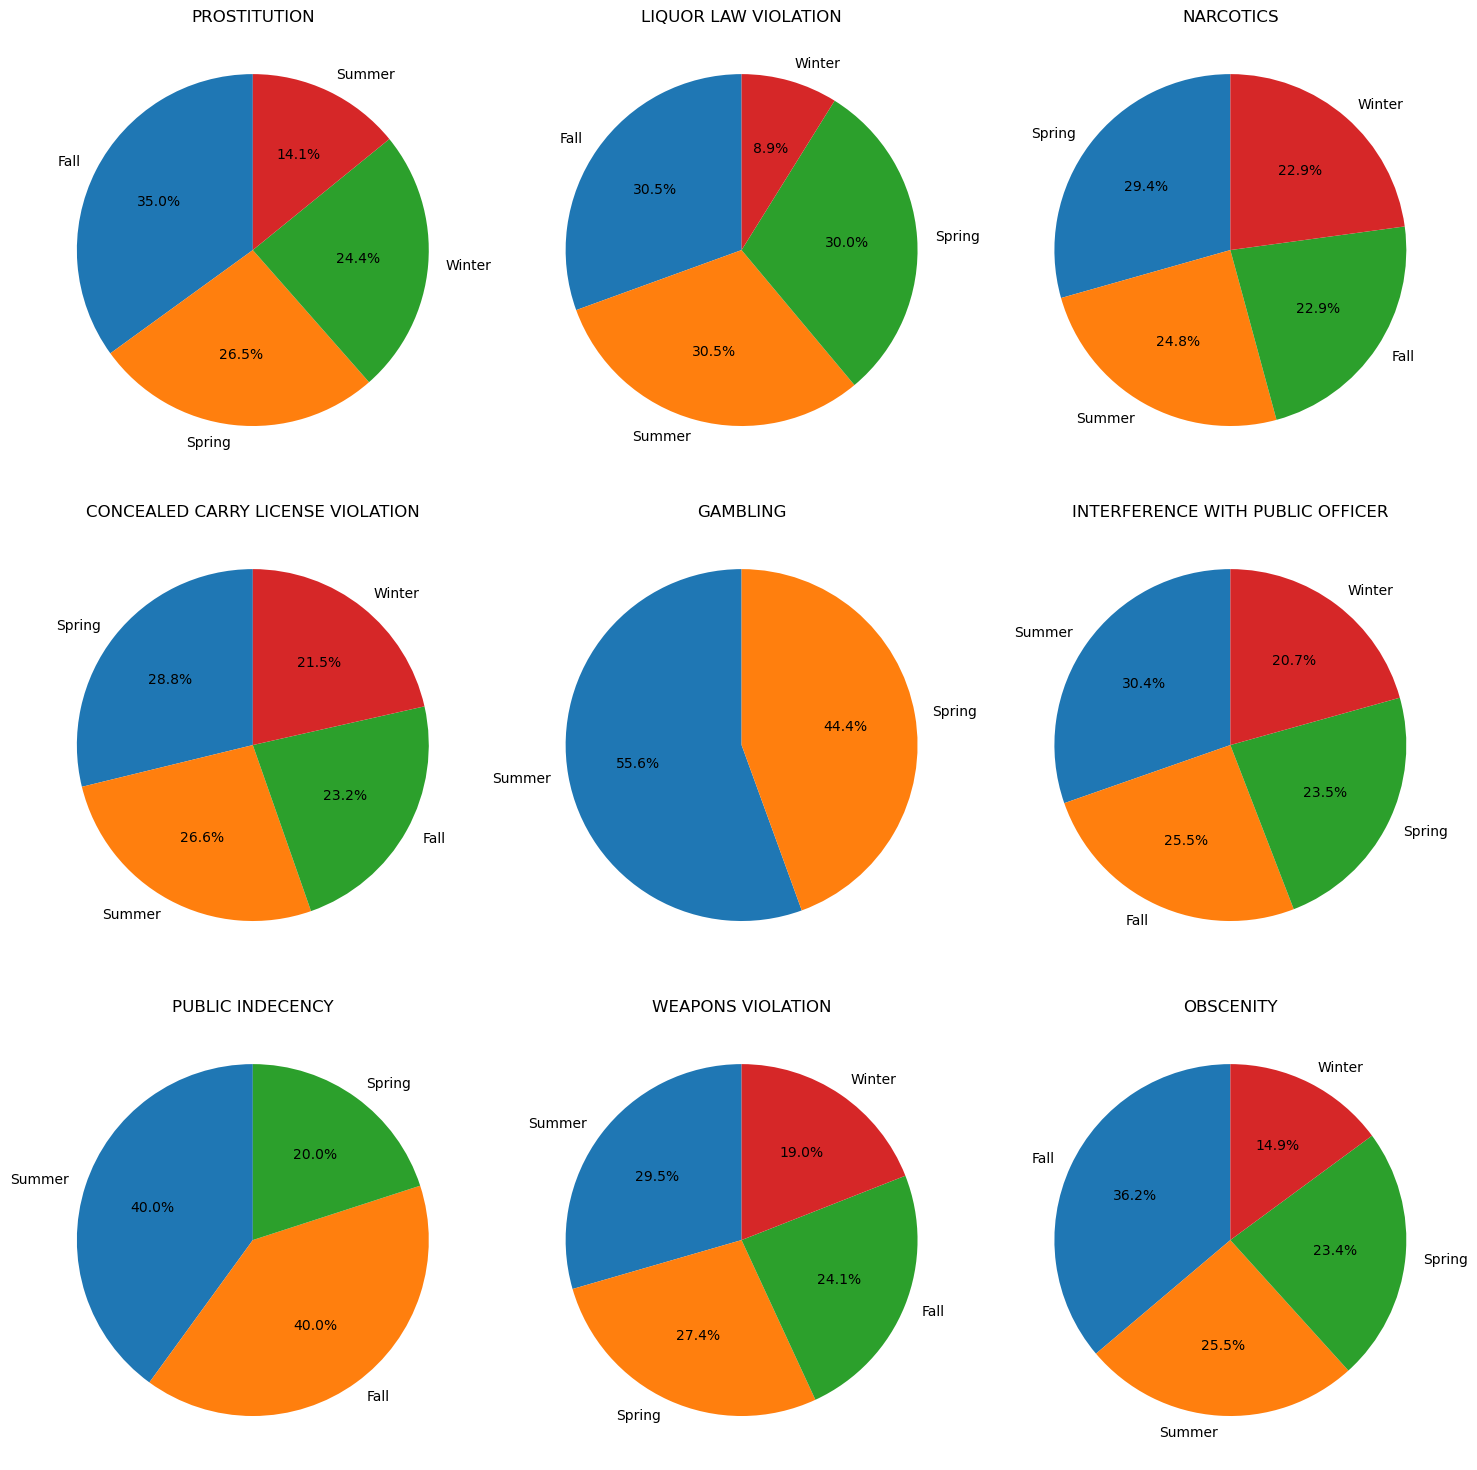

In [166]:
primary_types = ['PROSTITUTION', 'LIQUOR LAW VIOLATION', 'NARCOTICS',
                 'CONCEALED CARRY LICENSE VIOLATION', 'GAMBLING',
                 'INTERFERENCE WITH PUBLIC OFFICER', 'PUBLIC INDECENCY',
                 'WEAPONS VIOLATION', 'OBSCENITY']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Loop through each primary type and plot the pie chart
for i, primary_type in enumerate(primary_types): 
    filtered_data = data[data['Primary Type'] == primary_type]
    season_counts = filtered_data['season'].value_counts()
    
    axes[i].pie(season_counts, labels=season_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(primary_type)


plt.tight_layout()
plt.show()


#### Domestic Crimes

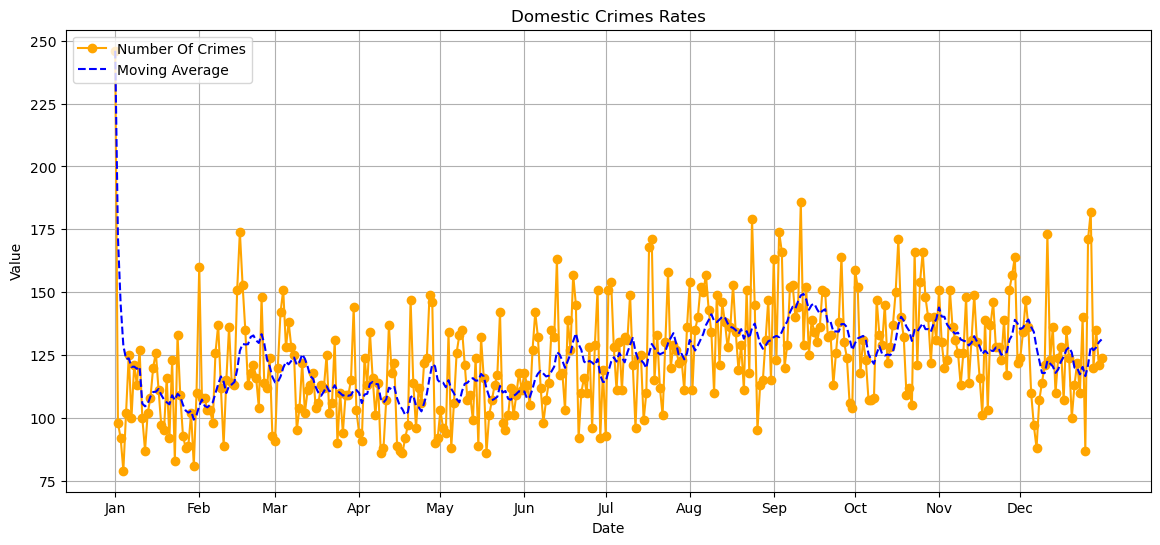

In [173]:
domestic_data = data[data['Domestic'] == True]
domestic_data = domestic_data.groupby(['day'])['ID'].aggregate('count')

# Calculate moving average
window_length = 10
domestic_avg = domestic_data.rolling(window=window_length, min_periods=1).mean()

# Plot the results
plt.figure(figsize=(14,6))
plt.plot(domestic_data.index, domestic_data, label='Number Of Crimes', marker='o', color='orange')
plt.plot(domestic_data.index, domestic_avg, label='Moving Average', linestyle='--', color='blue')


plt.xticks(
    ticks=[0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334],
    labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Domestic Crimes Rates')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

#### Homicide

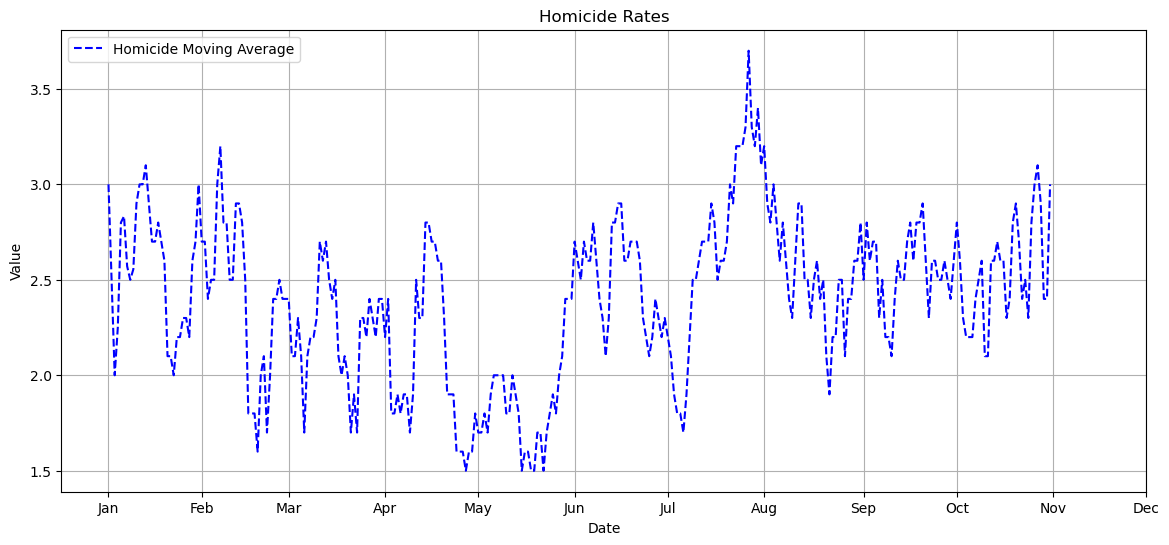

In [86]:
homicide_data = data[data['Primary Type'] == 'HOMICIDE']
homicide_data = homicide_data.groupby(['day'])['ID'].aggregate('count')

# Calculate moving average
window_length = 10
homicide_avg = homicide_data.rolling(window=window_length, min_periods=1).mean()

# Plot the results
plt.figure(figsize=(14,6))
# plt.plot(homicide_data.index, homicide_data, label='Homicide', marker='o', color='orange')
plt.plot(homicide_data.index, homicide_avg, label='Homicide Moving Average', linestyle='--', color='blue')


plt.xticks(
    ticks=[0, 30, 58, 89, 119, 150, 180, 211, 243, 273, 304, 334],
    labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Homicide Rates')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## ATE calculations using Matching

In [87]:
# Define the covariates (pre-treatment variables) for matching
covariates = ['hour', 'season', 'Beat', 'District', 'Community Area', 'Primary Type']

# Convert categorical variables to dummies (One-Hot Encoding)
data_dummies = pd.get_dummies(data[covariates], drop_first=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_dummies)

T = data['T'].astype(int)
Y = data['Arrest'].astype(int)

# Propensity score estimation using Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_scaled, T)

# Get the predicted propensity scores
data['ps'] = log_model.predict_proba(X_scaled)[:, 1]

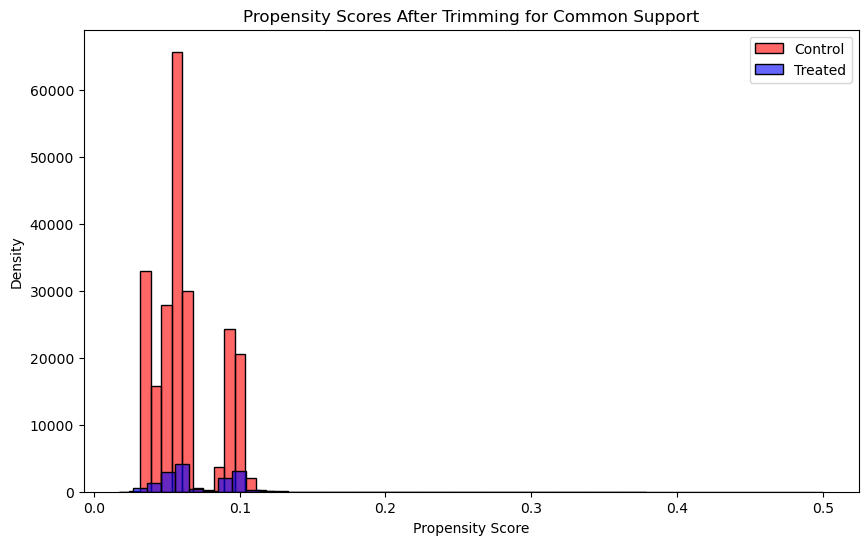

In [88]:
# Common support: Trim control units without overlap
treated_min = data[data['T'] == 1]['ps'].min()
treated_max = data[data['T'] == 1]['ps'].max()

# Remove control units outside this range
common_support = data[(data['ps'] >= treated_min) & (data['ps'] <= treated_max)]

# Create separate treated and control datasets
control = common_support[common_support['T'] == 0]
treated = common_support[common_support['T'] == 1]

# Visualize propensity scores after trimming for common support
plt.figure(figsize=(10,6))
sns.histplot(control['ps'], bins=50, color='red', alpha=0.6, label='Control')
sns.histplot(treated['ps'], bins=50, color='blue', alpha=0.6, label='Treated')
plt.title('Propensity Scores After Trimming for Common Support')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()


In [89]:
def calculate_ate(control, treated, k=K):
    """
    ATE estimation using Nearest Neighbors matching.
    Args:
        control (pd.DataFrame): Control group data
        treated (pd.DataFrame): Treated group data
        k (int): Number of nearest neighbors to consider
    Returns:
        ATE (float): Estimated Average Treatment Effect
    """
    
    # Matching using nearest neighbors (1-to-1 matching)
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(control[['ps']])
    distances, indices = nn.kneighbors(treated[['ps']])

    # Find matched control samples
    matched_controls = control.iloc[indices.flatten()]

    # Combine treated and matched control samples into one dataset
    matched_data = pd.concat([treated, matched_controls])

    # Estimate ATE
    ATE = matched_data.groupby('T')['Arrest'].mean().diff().iloc[-1]
    return ATE

def bootstrap_ate(df, n_bootstrap=NUM_SAMPLES, confidence=CONFIDENCE):
    """
    Bootstrap estimation of Average Treatment Effect (ATE) with confidence intervals.
    Args:
        df (pd.DataFrame): Input data
        n_bootstrap (int): Number of bootstrap samples
        alpha (float): p-value for confidence interval
    Returns:
        ate_mean (float): Mean ATE estimate
        ate_ci_lower (float): Lower bound of confidence interval
        ate_ci_upper (float): Upper bound of confidence interval
    """

    ate_estimates = []
    for _ in range(n_bootstrap):
        # Resample with replacement
        df_resample = resample(df)
        control = df_resample[df_resample['T'] == 0]
        treated = df_resample[df_resample['T'] == 1]
        # Calculate ATE on the resampled data
        ate_estimate = calculate_ate(control, treated)
        ate_estimates.append(ate_estimate)
    
    # Calculate the CI percentiles
    lower_bound = np.percentile(ate_estimates, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(ate_estimates, (1 + confidence) / 2 * 100)
    
    return np.mean(ate_estimates), lower_bound, upper_bound


# Todo: Calculate with NUM_SAMPLES
ate_mean, ate_ci_lower, ate_ci_upper = bootstrap_ate(data, 10, CONFIDENCE)
print(f'ATE: {ate_mean:.4f}')
print(f'{CONFIDENCE * 100}% Confidence Interval: [{ate_ci_lower:.4f}, {ate_ci_upper:.4f}]')

ATE: 0.0105
95.0% Confidence Interval: [0.0069, 0.0152]


## Different effects of T in winter vs other seasons

In [90]:
# Group by Season and Treatment to calculate arrest rates
arrest_rates = data.groupby(['season', 'T'])['Arrest'].mean().unstack()
arrest_rates

T,False,True
season,,
Fall,0.100637,0.116181
Spring,0.133581,0.148162
Summer,0.115421,0.122386
Winter,0.119204,0.110707


In [91]:
df = data[['Arrest', 'T', 'season']]

# One-Hot Encoding for 'season'
df = pd.get_dummies(df, columns=['season'], drop_first=False)

# Interaction terms between 'T' and seasons
df['T:season_Winter'] = df['T'] * df['season_Winter']
df['T:season_Fall'] = df['T'] * df['season_Fall']
df['T:season_Spring'] = df['T'] * df['season_Spring']
df['T:season_Summer'] = df['T'] * df['season_Summer']

# Features (X) and target variable (y)
X = df[['T:season_Winter', 'T:season_Spring', 'T:season_Summer', 'T:season_Fall']]
y = df['Arrest']

def calculate_coefficients(X, y):
    """
    Calculate coefficients for the logistic regression model.
    Args:
        X (pd.DataFrame): Input features
        y (pd.Series): Target variable
    Returns:
        coefficients (np.array): Array of coefficients
    """

    # Logistic Regression model (balanced classes)
    logit_model = LogisticRegression(class_weight='balanced')
    logit_model.fit(X, y)

    # Get the coefficients
    coefficients = logit_model.coef_[0]
    intercept = logit_model.intercept_

    return np.hstack([intercept, coefficients])

def bootstrap_coefficients(X, y, n_bootstrap=NUM_SAMPLES, confidence=CONFIDENCE):
    """
    Bootstrap estimation of coefficients for the logistic regression model.
    Args:
        X (pd.DataFrame): Input features
        y (pd.Series): Target variable
        n_bootstrap (int): Number of bootstrap samples
    Returns:
        bootstrap_coefs (np.array): Array of bootstrap coefficients
    """
    bootstrap_coefs = []
    for _ in range(n_bootstrap):
        # Resample the training data with replacement
        X_resample, y_resample = resample(X, y)

        # Calculate coefficients on the resampled data
        coefs = calculate_coefficients(X_resample, y_resample)
        bootstrap_coefs.append(coefs)

    ci_lower = np.percentile(bootstrap_coefs, ((1 - confidence) / 2) * 100, axis=0)
    ci_upper = np.percentile(bootstrap_coefs, ((1 + confidence) / 2) * 100, axis=0)
    average_coefs = np.mean(bootstrap_coefs, axis=0)
    return average_coefs, ci_lower, ci_upper
    

# Todo: Calculate with NUM_SAMPLES
average_coefs, ci_lower, ci_upper = bootstrap_coefficients(X, y, 10, CONFIDENCE)
coef_names = ['Intercept', 'T:Winter', 'T:Spring', 'T:Summer', 'T:Fall']
for name, coef, lower, upper in zip(coef_names, average_coefs, ci_lower, ci_upper):
    print(f'{name}:\nAverage value: {coef:.4f}\n95% Confidence Interval: [{lower:.4f}, {upper:.4f}]\n')

Intercept:
Average value: -0.0069
95% Confidence Interval: [-0.0089, -0.0049]

T:Winter:
Average value: -0.0584
95% Confidence Interval: [-0.1339, 0.0102]

T:Spring:
Average value: 0.2712
95% Confidence Interval: [0.2262, 0.3233]

T:Summer:
Average value: 0.0337
95% Confidence Interval: [-0.0114, 0.0602]

T:Fall:
Average value: 0.0047
95% Confidence Interval: [-0.0594, 0.0775]



In [104]:
# Todo: Calculate with NUM_SAMPLES
seasons_dfs = [(season_name, data[data['season'] == season_name]) for season_name in seasons_mapping.keys()]

for season in seasons_dfs:
    season_name, df = season
    ate_mean, ate_ci_lower, ate_ci_upper = bootstrap_ate(df, 10, CONFIDENCE)

    print(f'ATE of {season_name}: {ate_mean:.4f}')
    print(f'{CONFIDENCE * 100}% Confidence Interval: [{ate_ci_lower:.4f}, {ate_ci_upper:.4f}]\n')

ATE of Winter: -0.0030
95.0% Confidence Interval: [-0.0152, 0.0092]

ATE of Spring: 0.0114
95.0% Confidence Interval: [0.0055, 0.0179]

ATE of Summer: 0.0118
95.0% Confidence Interval: [0.0024, 0.0192]

ATE of Fall: 0.0203
95.0% Confidence Interval: [0.0109, 0.0322]

